# **Rakuten France Classification des données des produits multimodaux**
<br>
<br>

## 1. Remise en contexte

Notre **projet** s'inscrit dans le cadre du challenge **Rakuten France Multimodal Product Data Classification**. Nous avions présenté dans un rapport précédent notre exploration des données, ainsi que leur nettoyage. 
Dans la suite de ce rapport, nous allons présenté notre travail sur la **modélisation de ces données**. Pour rappel, l'objectif est de pouvoir prédire le **code produit** des objets vendus sur Rakuten en fonction des informations les décrivant. 

<br>
<br>

## 2. Modélisation sur les données textuelles


### 2.1. Import des données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import chi2_contingency
import os
import sys
from scipy import sparse
import statsmodels.api
import PIL
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
from googletrans import Translator
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout, LSTMCell
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from gensim.models import Word2Vec

C:\Users\Fenzhengrou\anaconda3\envs\data-scientest\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('rakuten_data_preproc.csv', index_col= 0)
df.head()

,image,image_size,prdtypecode,designation_description,avec_description,designation_description_nbr_mot,prdcat
ID,,,,,,,
0,image_1263597046_product_3804725264.jpg,14010,10,"['olivia', 'personalisiertes', 'notizbuch', 's...",0,9,Livres
1,image_1008141237_product_436067568.jpg,14854,2280,"['journal', 'arts', 'art', 'marche', 'salon', ...",0,20,Livres
2,image_938777978_product_201115110.jpg,6898,50,"['grand', 'stylet', 'ergonomique', 'bleu', 'ga...",1,80,Jeux
3,image_457047496_product_50418756.jpg,14404,1280,"['peluche', 'donald', 'europe', 'disneyland', ...",0,6,Jouets & figurines
4,image_1077757786_product_278535884.jpg,20435,2705,"['guerre', 'tuques', 'luc', 'grandeur', 'veut'...",1,18,Livres


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74854 entries, 0 to 84915
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   image                            74854 non-null  object
 1   image_size                       74854 non-null  int64 
 2   prdtypecode                      74854 non-null  int64 
 3   designation_description          74854 non-null  object
 4   avec_description                 74854 non-null  int64 
 5   designation_description_nbr_mot  74854 non-null  int64 
 6   prdcat                           74854 non-null  object
dtypes: int64(4), object(3)
memory usage: 4.6+ MB


### 2.2. Pre-processing des données

#### 2.2.1. Traduction des textes en français

Lors de notre exploration des données, nous avions remarqué que les **données textuelles n'étaient pas nécessairement en français**. Cela pourrait, par la suite, influencer négativement l'apprentissage de nos modèles. Pour adresser ce problème, nous avons décidé de **traduire l'ensemble des textes en français**.

La traduction des données a été réalisé avec la librairie **googletrans**. Cette librairie fait appel à l'API de Google Translate. Du fait de la taille importante des données à traduire, nous avons dû réaliser cette traduction de manière **itérative**. 

Nous pouvons retrouver le **script** permettant cette traduction ci-dessous :

In [4]:
'''
import pandas as pd
import numpy as np
import string

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('french'))

from googletrans import Translator
translator = Translator()

def word_translate(words):
    """
    translate all in french and remove stopwords
    input words : a list of words
    
    """            
    #translate all in french
    words_trans=[]
    translations = translator.translate(words, dest='fr')
    for word in translations:
        words_trans.append(word.text.split(" "))
    words_trans_flatten = [item for sublist in words_trans for item in sublist]
        
    # convert to lower case
    words_trans_flatten = [w.lower() for w in words_trans_flatten]
    
    # filter out stop words    
    words_final = [w for w in words_trans_flatten if not w in stop_words]
    
    return words_final


words = pd.read_csv('designation-description.csv', index_col=0, squeeze=True)
#words = words.loc[4547:]

table = str.maketrans('', '', string.punctuation)

with open('traduction_designation-description.txt', 'a', encoding='utf-8') as f:
    for w, index in zip(words.values, words.index):
        w = w.translate(table).split(' ')
        w_trans = word_translate(w)
        f.write(str(w_trans)+'\n')
        print(index)
        #print(w_trans)
'''

'\nimport pandas as pd\nimport numpy as np\nimport string\n\nimport nltk\nnltk.download(\'stopwords\')\nfrom nltk.corpus import stopwords\n\nstop_words = set(stopwords.words(\'french\'))\n\nfrom googletrans import Translator\ntranslator = Translator()\n\ndef word_translate(words):\n    """\n    translate all in french and remove stopwords\n    input words : a list of words\n    \n    """            \n    #translate all in french\n    words_trans=[]\n    translations = translator.translate(words, dest=\'fr\')\n    for word in translations:\n        words_trans.append(word.text.split(" "))\n    words_trans_flatten = [item for sublist in words_trans for item in sublist]\n        \n    # convert to lower case\n    words_trans_flatten = [w.lower() for w in words_trans_flatten]\n    \n    # filter out stop words    \n    words_final = [w for w in words_trans_flatten if not w in stop_words]\n    \n    return words_final\n\n\nwords = pd.read_csv(\'designation-description.csv\', index_col=0, sq

En sortie de ce script, nous avons un fichier **traduction_designation-description.txt** que nous allons maintenant intégrer à notre dataframe :

In [5]:
traduction = pd.read_table("traduction_designation-description.txt", header=None, squeeze=True)
traduction.index = df.index
traduction[:5]

C:\Users\Fenzhengrou\AppData\Local\Temp\ipykernel_12308\3271731793.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  traduction = pd.read_table("traduction_designation-description.txt", header=None, squeeze=True)


ID
0    ['olivia', 'personnalisé', 'carnet', 'pages', ...
1    ['journal', 'art', 'art', 'marche', 'salon', '...
2    ['grand', 'stylet', 'ergonomique', 'bleu', 'ma...
3    ['peluche', 'donald', "l'europe", '\uf0d7', 'd...
4    ['guerre', 'tuques', 'luc', 'grandeur', 'veut'...
Name: 0, dtype: object

In [6]:
stop_words = set(stopwords.words('french') + stopwords.words('english'))
mots_vides = ["x", "cm", "mm", "h", "g", "peut", "être", 'e',"l'",'x','p','re', 'li','x','b','d','h', 'pla','br','id','al','ra','pla','sine','r','g','v','u','f']
stop_words.update(mots_vides)


def word_split(text):
    """split text into words, remove non alphabetic tokens and stopwords"""
    
    # suppression de la ponctuation
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(table)
    
    # séparation des textes en listes de mots
    tokens = word_tokenize(text)
    
    # conversion en minuscule
    tokens = [w.lower() for w in tokens]
    
    # restriction aux charactères alphabétiques
    words = [word for word in tokens if word.isalpha()]

    # filtrage des stopwords
    words = [w for w in words if not w in stop_words]
    
    return words

In [7]:
traduction = traduction.apply(word_split)
traduction[:5]

ID
0    [olivia, personnalisé, carnet, pages, grille, ...
1    [journal, art, art, marche, salon, art, asiati...
2    [grand, stylet, ergonomique, bleu, manette, je...
3    [peluche, donald, europe, disneyland, marionne...
4    [guerre, tuques, luc, grandeur, veut, organise...
Name: 0, dtype: object

In [8]:
# Stemming
stemmer = SnowballStemmer(language='french')
traduction_stem = traduction.apply(lambda liste: [stemmer.stem(item) for item in liste])
traduction_stem[:5]

ID
0    [olivi, personnalis, carnet, pag, grill, point...
1    [journal, art, art, march, salon, art, asiat, ...
2    [grand, stylet, ergonom, bleu, manet, jeu, nin...
3    [peluch, donald, europ, disneyland, marionnet,...
4    [guerr, tuqu, luc, grandeur, veut, organis, je...
Name: 0, dtype: object

In [9]:
df['text_data'] = traduction
df['stemmed_text_data'] = traduction_stem

In [10]:
df.head()

,image,image_size,prdtypecode,designation_description,avec_description,designation_description_nbr_mot,prdcat,text_data,stemmed_text_data
ID,,,,,,,,,
0,image_1263597046_product_3804725264.jpg,14010,10,"['olivia', 'personalisiertes', 'notizbuch', 's...",0,9,Livres,"[olivia, personnalisé, carnet, pages, grille, ...","[olivi, personnalis, carnet, pag, grill, point..."
1,image_1008141237_product_436067568.jpg,14854,2280,"['journal', 'arts', 'art', 'marche', 'salon', ...",0,20,Livres,"[journal, art, art, marche, salon, art, asiati...","[journal, art, art, march, salon, art, asiat, ..."
2,image_938777978_product_201115110.jpg,6898,50,"['grand', 'stylet', 'ergonomique', 'bleu', 'ga...",1,80,Jeux,"[grand, stylet, ergonomique, bleu, manette, je...","[grand, stylet, ergonom, bleu, manet, jeu, nin..."
3,image_457047496_product_50418756.jpg,14404,1280,"['peluche', 'donald', 'europe', 'disneyland', ...",0,6,Jouets & figurines,"[peluche, donald, europe, disneyland, marionne...","[peluch, donald, europ, disneyland, marionnet,..."
4,image_1077757786_product_278535884.jpg,20435,2705,"['guerre', 'tuques', 'luc', 'grandeur', 'veut'...",1,18,Livres,"[guerre, tuques, luc, grandeur, veut, organise...","[guerr, tuqu, luc, grandeur, veut, organis, je..."


Nous avons désormais deux nouvelles colonnes dans notre dataset : **text_data** et **stemmed_text_data** correspondant aux données textuelles netoyées et traduites. **stemmed_text_data** est issu d'une étape de pré-processing supplémentaire, le stemming, lors de laquelle nous avons récupéré la base des mots (semblable à la racine). 

Nous avons ainsi pu tester par la suite les résultats et la robustesse des modèles en fonctions des données textuelles, **avec ou sans stemming**.

Enfin pour conclure cette partie, nous pouvons **visualiser** nos données maintenant qu'elles sont traduites:

Il y a 2175362 mots dans la categorie Livres


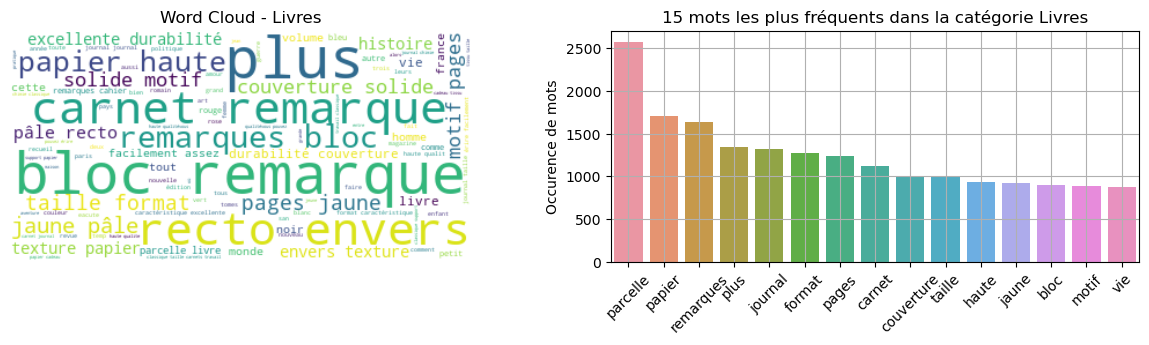

Il y a 1988632 mots dans la categorie Jeux


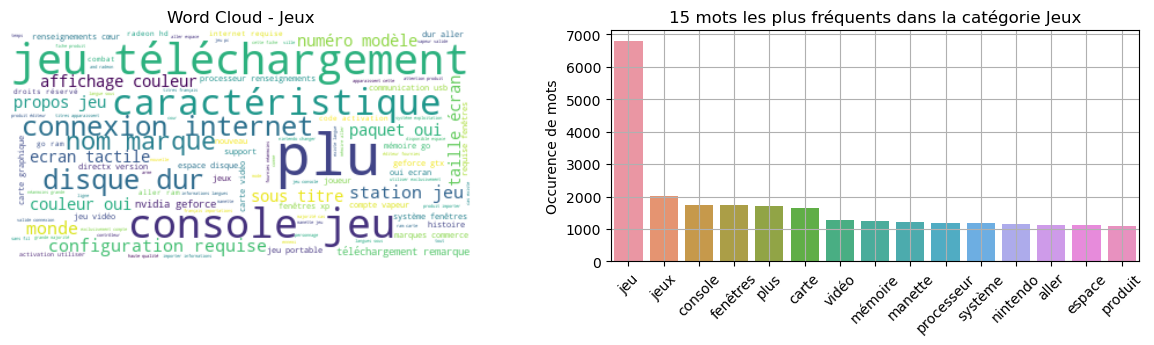

Il y a 5718765 mots dans la categorie Jouets & figurines


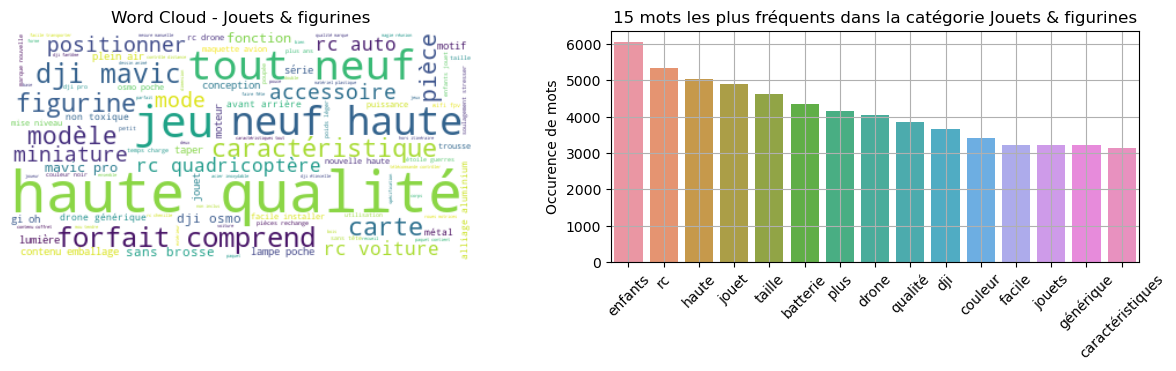

Il y a 3761286 mots dans la categorie Meubles


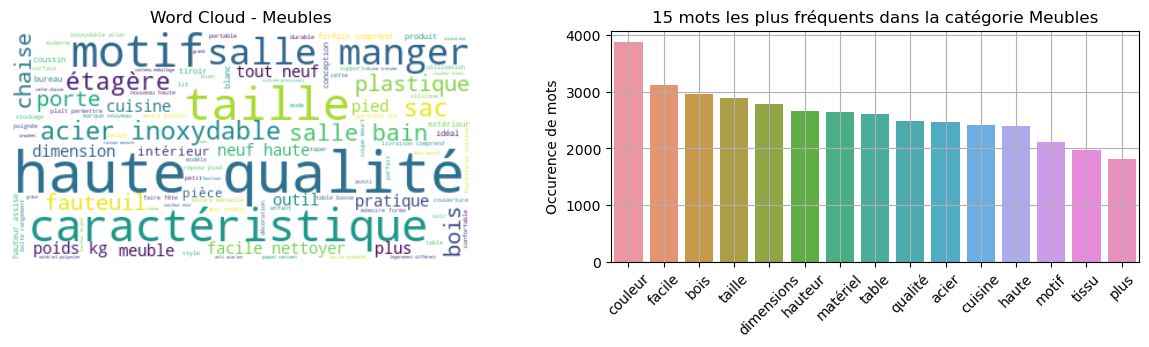

Il y a 5784964 mots dans la categorie Equipements divers


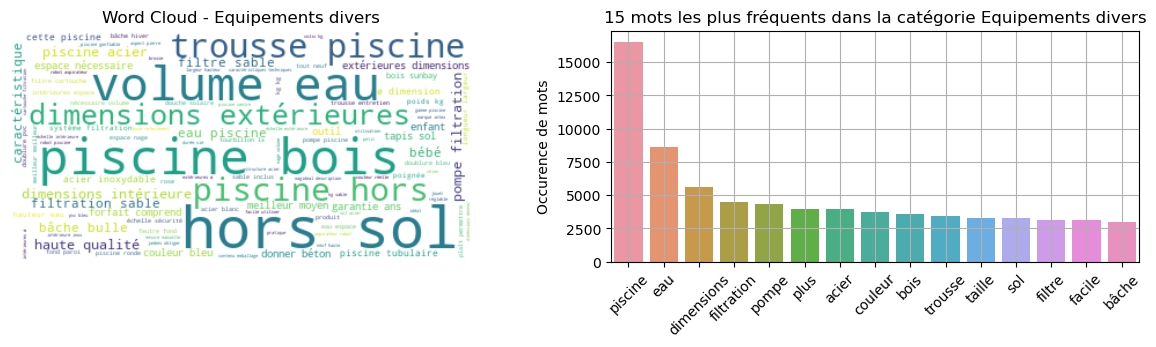

Il y a 4654501 mots dans la categorie Deco


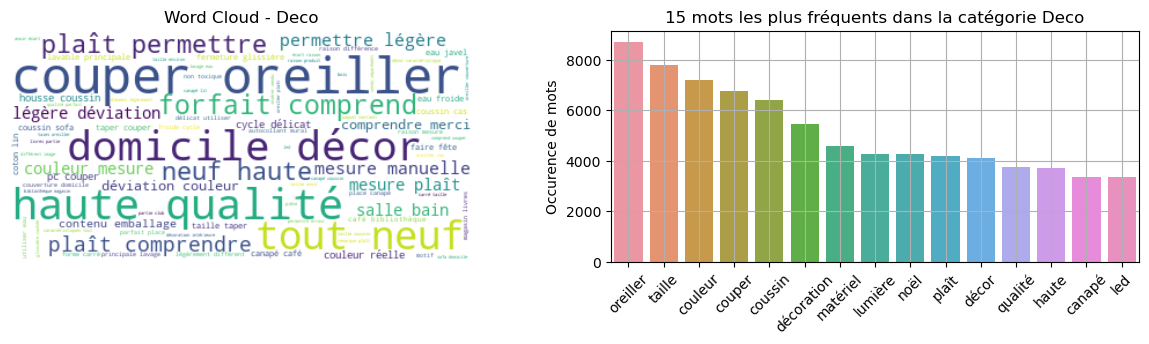

Il y a 343263 mots dans la categorie Autres


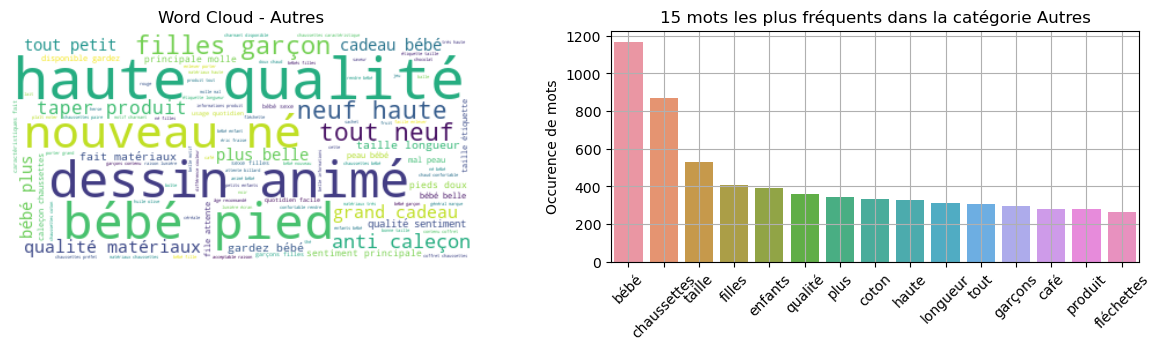

In [11]:
dict_cat = {'Livres':[10, 2280, 2403, 2522, 2705],
            'Jeux':[40, 50, 60, 2462, 2905],
            'Jouets & figurines':[1140, 1160, 1180, 1280, 1281, 1300, 1302],
            'Meubles':[1560, 2582],
            'Equipements divers':[1320, 2220, 2583, 2585],
            'Deco':[1920, 2060],
            'Autres':[1301, 1940]}

for categorie in dict_cat.keys():
    text = " ".join(w for text in df[df.prdcat == categorie]['text_data'] for w in text)
    print ( ("Il y a {} mots dans la categorie "+categorie).format(len(text)))

    word_count = Counter(text.split(" "))
    mots = [m[0] for m in word_count.most_common(15)]
    freq = [m[1] for m in word_count.most_common(15)]

    wordcloud = WordCloud(max_font_size=50, max_words=100, stopwords=stop_words, background_color="white").generate(text)

    plt.figure(figsize=(15, 3))
    plt.subplot(121)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('Word Cloud - '+categorie)
    plt.subplot(122)
    sns.barplot(x=mots, y=freq)
    plt.title('15 mots les plus fréquents dans la catégorie '+categorie)
    plt.xticks(rotation=45)
    plt.ylabel('Occurence de mots')
    plt.grid()
    plt.show()

### 2.3. Premiers modèles (modèles naifs)

#### 2.3.1. Échantillonnage des données 

In [12]:
X = df['text_data'].apply(lambda x : " ".join(w for w in x))
y = df['prdtypecode']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### 2.3.2. Vectorisation des variables explicatives 

Afin que nos données, sous forme de chaînes de caractères, puissent être utilisable par nos différents algorithmes, nous avons besoins de les transformer en données numériques. Pour cela, nous devons passer par une étape de vectorisation afin de transformer un texte en vecteur.    

<br>
Concernant la méthode de vectorisation, **CountVectorizer** pourrait être utile pour comprendre le type de texte par la fréquence des mots qu'il contient. Mais ses **inconvénients**, majeurs, sont :

* Son **incapacité** à identifier les **mots les plus importants** et les moins importants pour l'analyse;
* Il considère simplement les mots qui sont **abondants** dans un corpus comme le mot le plus **significatif** statistiquement;
* Il n'identifie pas les relations entre les mots telles que la **similitude linguistique**.

Une autre méthode de vectorisation est **TfidfVectorizer** qui est basée sur le calcul de **TF-IDF** des mots. Elle est ici **plus intéressant** que **CountVectorizer** car il se concentre non seulement sur la fréquence des mots présents dans le corpus, mais fournit également l'importance des mots. On peut alors **supprimer les mots qui sont moins importants** pour l'analyse, rendant ainsi la construction du modèle moins complexe en **réduisant les dimensions**.


In [13]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

In [14]:
X_train.shape

(59883, 62831)

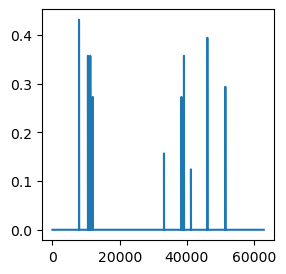

In [15]:
plt.figure(figsize=(3,3))
plt.plot(X_train[0,:]);

Nous pouvons voir sur le graphique ci-dessus que **bon nombre de mots** sont représentés par un **zéro** :  **TfidfVectorizer** considère que l'importance de ces mots est nulle. Cependant, ils sont bien présents et leurs poids en terme de bits n'est pas négligeable :

In [16]:
sys.getsizeof(X_train) / 1024 **3 # Gb en memoire

28.03287497162819

Pour remédier à ce problème, nous pouvons transformer nos matrices en **matrices creuses** :

In [17]:
X_train = sparse.csr_matrix(X_train)
X_test = sparse.csr_matrix(X_test)

In [18]:
sys.getsizeof(X_train) # bit 

48

Nous répétons ces mêmes étapes pour les données avec stemming :

In [19]:
X_stem = df['stemmed_text_data'].apply(lambda x : " ".join(w for w in x))
y_stem = df['prdtypecode']

X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem, y_stem, test_size=0.2, random_state=123)

In [20]:
vectorizer_stem = TfidfVectorizer()

X_train_stem = vectorizer_stem.fit_transform(X_train_stem).toarray()
X_test_stem = vectorizer_stem.transform(X_test_stem).toarray()

In [21]:
X_train_stem.shape

(59883, 41086)

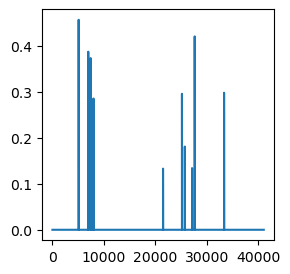

In [22]:
plt.figure(figsize=(3,3))
plt.plot(X_train_stem[0,:]);

In [23]:
X_train_stem = sparse.csr_matrix(X_train_stem)
X_test_stem = sparse.csr_matrix(X_test_stem)

#### 2.3.3. Premier modèle naïf : régression logistique

Nous avons testé différent **modèles simples (SVM, KNN, Decision Tree, ...)** et **modèles d'ensemble (Random Forest, XGBoost, ...)**. Par soucis de concision, nous allons présenter deux de ces modèles ici : un premier modèle de **régression logistique**, puis un modèle **random forest**.

In [24]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1.0)
lr.fit(X_train, y_train)

C:\Users\Fenzhengrou\anaconda3\envs\data-scientest\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [25]:
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

0.8714827246463938
0.7826464498029524
              precision    recall  f1-score   support

          10       0.38      0.48      0.42       561
          40       0.71      0.54      0.61       442
          50       0.80      0.78      0.79       286
          60       0.97      0.84      0.90       159
        1140       0.76      0.77      0.77       447
        1160       0.85      0.88      0.87       665
        1180       0.75      0.62      0.68       117
        1280       0.69      0.64      0.66       875
        1281       0.77      0.50      0.61       336
        1300       0.86      0.92      0.89       920
        1301       0.94      0.83      0.88       133
        1302       0.83      0.72      0.77       447
        1320       0.81      0.77      0.79       611
        1560       0.78      0.80      0.79       905
        1920       0.89      0.89      0.89       752
        1940       0.94      0.63      0.75       121
        2060       0.76      0.78      0.77

Classe prédite,10,40,50,60,1140,1160,1180,1280,1281,1300,...,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
Classe réelle,,,,,,,,,,,,,,,,,,,,,
10,269,8,0,1,2,8,1,10,1,0,...,0,158,50,0,6,1,4,1,34,0
40,50,238,15,0,9,15,2,13,7,2,...,2,53,10,7,0,0,1,3,9,0
50,2,3,222,1,8,3,1,1,1,6,...,1,5,1,14,1,0,1,0,0,0
60,0,5,7,133,0,0,0,0,0,0,...,0,0,0,14,0,0,0,0,0,0
1140,10,8,1,1,344,10,4,21,0,0,...,0,23,12,0,5,0,3,0,1,0
1160,26,4,0,0,8,587,0,1,0,0,...,0,23,9,0,3,0,0,0,2,0
1180,5,0,0,0,6,6,73,2,5,1,...,0,9,2,1,3,0,1,0,2,0
1280,16,10,1,1,35,3,0,558,20,107,...,4,19,15,2,7,0,7,3,1,0
1281,14,14,1,0,9,13,8,69,168,0,...,0,9,5,2,3,0,3,0,4,0


Nous pouvons voir que pour un premier modèle, le **score est plutôt honorable (0.78)**, cependant le modèle a tendance à **sur-apprendre** des données **(score de 0.87 sur les données d'entraînement)**. Ceci est mauvais signe pour la **robustesse** du modèle face à de **nouvelles données**.

Nous pouvons également afficher les coefficients de chaques code produit et retenir les trois mots les plus important :

In [26]:
for i in range(len(lr.classes_)):
    feats = {}
    for feature, coef in zip(vectorizer.get_feature_names_out(), lr.coef_[i]):
        feats[feature] = coef 
    importances = pd.DataFrame.from_dict(feats, orient= 'index').rename(columns= {0: 'code produit '+str(lr.classes_[i])+' coef'})
    print(importances.sort_values(by= 'code produit '+str(lr.classes_[i])+' coef', ascending= False).head(3))

          code produit 10 coef
histoire              3.481937
guide                 3.117913
livre                 3.019928
          code produit 40 coef
importer              7.329503
version               5.572426
japonais              5.567746
            code produit 50 coef
manette                 6.359974
skylanders              6.314897
nintendo                5.616863
          code produit 60 coef
console               6.909586
jeu                   6.529719
nintendo              5.897100
           code produit 1140 coef
figurine                10.841392
chemise                  6.846167
figurines                6.537137
         code produit 1160 coef
vf                     9.155594
carte                  8.751700
réunion                8.729306
            code produit 1180 coef
héros                     6.778670
marteau                   6.357710
miniatures                4.848156
          code produit 1280 coef
doudou                  8.082670
peluche                 6.

Testons à présent ce même modèle sur les données textuelles **après stemming** :

In [27]:
lr_stem = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1.0)
lr_stem.fit(X_train_stem, y_train_stem)

C:\Users\Fenzhengrou\anaconda3\envs\data-scientest\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [28]:
print(lr_stem.score(X_train_stem, y_train_stem))
print(lr_stem.score(X_test_stem, y_test_stem))

y_pred_stem = lr_stem.predict(X_test_stem)

print(classification_report(y_test_stem, y_pred_stem))

pd.crosstab(y_test_stem, y_pred_stem, rownames=['Classe réelle'], colnames=['Classe prédite'])

0.8553679675366965
0.7774363769955247
              precision    recall  f1-score   support

          10       0.37      0.45      0.41       561
          40       0.65      0.56      0.60       442
          50       0.82      0.77      0.79       286
          60       0.97      0.84      0.90       159
        1140       0.75      0.76      0.75       447
        1160       0.84      0.88      0.86       665
        1180       0.76      0.60      0.67       117
        1280       0.69      0.63      0.66       875
        1281       0.76      0.48      0.59       336
        1300       0.85      0.93      0.89       920
        1301       0.93      0.82      0.87       133
        1302       0.83      0.71      0.76       447
        1320       0.81      0.76      0.79       611
        1560       0.77      0.79      0.78       905
        1920       0.88      0.89      0.89       752
        1940       0.88      0.70      0.78       121
        2060       0.75      0.77      0.76

Classe prédite,10,40,50,60,1140,1160,1180,1280,1281,1300,...,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
Classe réelle,,,,,,,,,,,,,,,,,,,,,
10,254,13,0,0,2,10,1,7,1,1,...,0,162,55,0,5,2,5,2,32,0
40,50,246,12,0,12,15,1,13,6,2,...,2,51,11,6,0,0,1,2,6,0
50,3,8,220,1,8,4,1,0,1,6,...,0,4,0,15,2,0,1,0,0,0
60,0,5,8,133,0,0,0,0,0,0,...,0,0,0,13,0,0,0,0,0,0
1140,19,12,0,1,339,13,2,19,0,0,...,0,18,10,0,4,0,3,0,2,0
1160,25,8,0,0,5,588,0,1,1,2,...,0,18,12,0,3,0,0,0,0,0
1180,7,1,0,0,7,9,70,3,5,1,...,0,4,2,1,2,0,1,0,1,0
1280,15,14,1,1,31,3,0,550,19,115,...,3,20,15,2,7,0,7,3,3,0
1281,14,16,1,0,8,11,9,69,162,2,...,0,6,6,2,5,0,4,0,4,0


Les **performances** de ce modèle semblent sensiblement **inférieures** à celles du modèle sans stemming. Cependant le **sur-apprentissage** est légèrement **moins important**.

Ci-dessous les mots les plus importants par code produit:

In [29]:
for i in range(len(lr_stem.classes_)):
    feats = {}
    for feature, coef in zip(vectorizer_stem.get_feature_names_out(), lr_stem.coef_[i]):
        feats[feature] = coef 
    importances = pd.DataFrame.from_dict(feats, orient= 'index').rename(columns= {0: 'code produit '+str(lr_stem.classes_[i])+' coef'})
    print(importances.sort_values(by= 'code produit '+str(lr_stem.classes_[i])+' coef', ascending= False).head(3))

         code produit 10 coef
histoir              3.302972
livr                 3.198572
guid                 3.000814
          code produit 40 coef
import                6.348600
version               5.284803
magideal              5.025991
           code produit 50 coef
skylander              6.373608
manet                  6.345280
nintendo               5.564111
          code produit 60 coef
consol                6.653465
jeu                   6.400219
nintendo              5.770956
         code produit 1140 coef
figurin               11.105799
chemis                 6.519289
gundam                 5.055301
         code produit 1160 coef
vf                     8.889278
réunion                8.605979
cart                   8.295101
         code produit 1180 coef
héros                  6.646676
marteau                5.936846
rôl                    4.482251
         code produit 1280 coef
doudou                 7.970118
peluch                 6.507454
figurin                6

#### 2.3.4. Second modèle : Random Forest

Regardons désormais les performances d'un modèle **random forest** sur les données sans et avec stemming :

In [30]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [31]:
print("score train : ", rf.score(X_train, y_train))
print("score test : ",rf.score(X_test, y_test))

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

score train :  0.9989980461900706
score test :  0.7690869013425957
              precision    recall  f1-score   support

          10       0.41      0.41      0.41       561
          40       0.69      0.57      0.62       442
          50       0.88      0.77      0.82       286
          60       0.99      0.86      0.92       159
        1140       0.76      0.79      0.78       447
        1160       0.83      0.90      0.86       665
        1180       0.73      0.61      0.66       117
        1280       0.68      0.61      0.65       875
        1281       0.71      0.54      0.61       336
        1300       0.84      0.92      0.88       920
        1301       0.93      0.80      0.86       133
        1302       0.88      0.67      0.76       447
        1320       0.80      0.74      0.77       611
        1560       0.72      0.83      0.77       905
        1920       0.90      0.90      0.90       752
        1940       0.81      0.65      0.72       121
        2060  

Classe prédite,10,40,50,60,1140,1160,1180,1280,1281,1300,...,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
Classe réelle,,,,,,,,,,,,,,,,,,,,,
10,232,23,0,0,3,13,1,4,2,1,...,1,164,60,1,11,1,5,1,27,0
40,32,251,6,0,7,19,3,12,7,2,...,0,51,14,18,2,0,1,1,11,0
50,2,5,219,0,6,3,1,0,1,4,...,0,7,1,20,3,0,1,1,1,0
60,0,2,4,137,0,0,0,0,1,0,...,0,0,0,14,1,0,0,0,0,0
1140,8,9,1,0,355,16,1,10,0,3,...,0,19,7,1,7,0,2,0,2,0
1160,7,4,0,0,5,600,2,1,0,0,...,0,32,7,0,3,0,0,0,2,0
1180,6,1,0,0,7,5,71,2,5,0,...,0,6,6,0,2,0,1,0,4,0
1280,6,18,1,1,43,4,0,537,27,122,...,0,17,12,2,11,0,9,3,0,0
1281,6,12,0,0,9,10,8,68,182,1,...,0,8,8,4,7,0,1,0,3,0


Les résultats sont moins bons que les deux modèles précédent : outre le **score moins bon** sur les données de l'échantillon test (0.77), le **sur-apprentissage** est **très important**.

Nous pouvons aussi regarder les mots les plus importants dans la prise de décision :

In [32]:
feats = {}
for feature, importance in zip(vectorizer.get_feature_names_out(), rf.feature_importances_):
    feats[feature] = importance 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})

importances.sort_values(by='Importance', ascending=False).head(15)

,Importance
piscine,0.013760
parcelle,0.008469
générique,0.007602
figurine,0.005961
jeu,0.004823
carte,0.004650
bébé,0.003832
vf,0.003469
livres,0.003461
eau,0.003437


Reprenons le modèle de **random forest** en l'entrainant sur les données **avec stemming** :

In [33]:
rf_stem = RandomForestClassifier()
rf_stem.fit(X_train_stem, y_train_stem)

RandomForestClassifier()

In [34]:
print("score train : ", rf_stem.score(X_train_stem, y_train_stem))
print("score test : ",rf_stem.score(X_test_stem, y_test_stem))

y_pred_stem = rf_stem.predict(X_test_stem)

print(classification_report(y_test_stem, y_pred_stem))

pd.crosstab(y_test_stem, y_pred_stem, rownames=['Classe réelle'], colnames=['Classe prédite'])

score train :  0.9988978508090777
score test :  0.7666154565493287
              precision    recall  f1-score   support

          10       0.38      0.38      0.38       561
          40       0.66      0.58      0.62       442
          50       0.84      0.79      0.81       286
          60       0.99      0.86      0.92       159
        1140       0.78      0.77      0.77       447
        1160       0.82      0.91      0.86       665
        1180       0.68      0.61      0.64       117
        1280       0.68      0.59      0.63       875
        1281       0.70      0.50      0.58       336
        1300       0.81      0.92      0.87       920
        1301       0.96      0.81      0.88       133
        1302       0.90      0.65      0.75       447
        1320       0.81      0.71      0.75       611
        1560       0.70      0.84      0.77       905
        1920       0.90      0.90      0.90       752
        1940       0.81      0.67      0.73       121
        2060  

Classe prédite,10,40,50,60,1140,1160,1180,1280,1281,1300,...,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
Classe réelle,,,,,,,,,,,,,,,,,,,,,
10,215,20,0,0,2,18,1,5,2,4,...,0,160,74,1,12,1,6,1,28,0
40,41,258,11,0,4,14,4,11,4,4,...,2,41,17,12,0,0,1,1,8,0
50,3,6,225,0,4,4,1,1,2,4,...,0,6,0,19,2,0,1,1,0,0
60,0,1,6,136,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
1140,9,15,2,0,344,15,5,11,0,3,...,1,22,11,0,5,0,1,0,1,0
1160,9,6,0,0,4,603,1,1,0,0,...,0,27,8,0,2,0,0,1,1,0
1180,5,3,0,0,5,5,71,2,4,1,...,0,3,7,0,2,0,1,0,5,0
1280,9,18,1,1,41,4,2,519,28,131,...,0,12,17,1,11,0,9,0,3,1
1281,6,14,0,0,8,16,5,71,168,1,...,0,9,4,5,9,0,2,0,7,0


In [35]:
feats = {}
for feature, importance in zip(vectorizer_stem.get_feature_names_out(), rf_stem.feature_importances_):
    feats[feature] = importance 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})

importances.sort_values(by='Importance', ascending=False).head(15)

,Importance
piscin,0.013616
parcel,0.008917
géner,0.007474
figurin,0.006824
cart,0.006318
jeu,0.004938
décor,0.004087
beb,0.004003
couleur,0.003954
eau,0.003928


Les résultats des deux modèles sont très proche, et tous les deux semblent moins robustes que les modèles de régression logistique.

Le **modèle de régression logistique sur les données avec stemming** semble être le **meilleur compromis** entre le **taux de bonnes prédictions (0.77)** et la **robustesse** du modèle.

### 2.4. Modèles complexes (Deep learning)

La classification par des modèles de Machine Learning avec la vectorization des mots (ex. TF-IDF) souffrent de 2 problèmes majeurs:
- La représentation vectorielle de chaque document du corpus est relativement grande. En effet, la taille du vecteur est égale à la taille de tout le vocabulaire du corpus. Avec autant de caractéristiques, les algorithmes de Machine Learning ont des difficultés à s'entraîner et identifier les dimensions les plus pertinentes.
- Les méthodes conduisent à une perte de la signification contextuelle des mots. Cela représente un problème sérieux car certains mots peuvent avoir plusieurs sens ou être utilisés de manière métaphorique. Par exemple, 'hot' dans 'hot weather' n'a pas la même signification que dans 'hot topic'.

Par conséquent, nous allons utiliser la méthode **word embedding** de Deep learning qui est capable en réduisant la dimension de capturer le contexte, la similarité sémantique et syntaxique (genre, synonymes, ...) d'un mot.

La taille d'embedding est choisi à 300 pour une taille de vocabulaire de 62 836 mots.

Plusier modèle de deep learning ont été testé avec la couche Embedding de keras. L'embedding simple avec des couches Dense ou avec un reseau de neuron recurent (GRU et LSTM) donnent des résultats avec **sur-apprentissage important**. L'embedding avec des modèle existant comme **Word2Vec de gensim** et **FastText de Facebook** permet d'améliorer l'apprentissage.

Ici, nous presentons uniquement deux modèles qui donne les meilleurs résultats parmi tous nos tests.



#### 2.4.1. Tokenization et encodage

In [36]:
X = df['text_data'].apply(lambda x : " ".join(w for w in x))
y = df['prdtypecode']

encoder =  LabelEncoder()
Y = encoder.fit_transform(y)

X_text_train, X_text_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

In [37]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_text_train)

In [38]:
word2idx = tokenizer.word_index
idx2word = tokenizer.index_word
vocab_size = len(word2idx)+1

In [39]:
X_train = tokenizer.texts_to_sequences(X_text_train)

X_test = tokenizer.texts_to_sequences(X_text_test)

In [40]:
max_length = 450

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

#### 2.4.2. RNN embedding avec FastText pré-entrainé 

Un modèle pré-entrainé en français de FastText (https://fasttext.cc/docs/en/crawl-vectors.html) a été téléechargé et utilisé ici. Les vecteurs de mots sont pré-entrainés sur le site Common Crawl et Wikipedia en utilisant fastText à l'aide de CBOW, en dimension 300, avec longueur de n-grammes de 5, une fenêtre de taille 5 et 10 négatifs.

In [55]:
# creation d'un dictionnaire avec embedding de FastText pré-entrainé
embedding_index = {}
f = open('cc.fr.300.vec', 'r', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_index))

Found 2000000 word vectors.


In [56]:
# creation d'une matrice d'embedding pour chaque mot dans notre dataset word2idx
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word2idx.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [57]:
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.005, patience=5, mode='max', 
                               restore_best_weights=True, verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', min_delta = 0.01, factor = 0.1, 
                                         patience = 3, cooldown = 4, verbose=1)

In [58]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            input_length=max_length, trainable=False)


modelRNNft = Sequential()
modelRNNft.add(embedding_layer)
modelRNNft.add(RNN(GRUCell(128), return_sequences=True))
#modelRNNft.add(RNN(LSTMCell(128), return_sequences=True)) # score identique entre GRU et LSTM, calcul tres long
modelRNNft.add(Dropout(0.3))
modelRNNft.add(GlobalAveragePooling1D())
modelRNNft.add(Dense(256, activation='relu'))
modelRNNft.add(Dropout(0.3))
modelRNNft.add(Dense(27, activation='softmax'))

modelRNNft.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 450, 300)          18850800  
                                                                 
 rnn_1 (RNN)                 (None, 450, 128)          165120    
                                                                 
 dropout_2 (Dropout)         (None, 450, 128)          0         
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [59]:
modelRNNft.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


training_history_RNNft = modelRNNft.fit(X_train, y_train, batch_size = 300, epochs=50, 
                             validation_data = [X_test, y_test],
                             callbacks= [early_stopping, reduce_learning_rate],
                             verbose = True)

Epoch 1/50
200/200 [==============================] - 205s 1s/step - loss: 2.6219 - accuracy: 0.2083 - val_loss: 1.9729 - val_accuracy: 0.3694 - lr: 0.0010
Epoch 2/50
200/200 [==============================] - 204s 1s/step - loss: 1.7847 - accuracy: 0.4285 - val_loss: 1.5677 - val_accuracy: 0.4981 - lr: 0.0010
Epoch 3/50
200/200 [==============================] - 206s 1s/step - loss: 1.5105 - accuracy: 0.5197 - val_loss: 1.3739 - val_accuracy: 0.5673 - lr: 0.0010
Epoch 4/50
200/200 [==============================] - 204s 1s/step - loss: 1.3513 - accuracy: 0.5745 - val_loss: 1.2760 - val_accuracy: 0.5994 - lr: 0.0010
Epoch 5/50
200/200 [==============================] - 204s 1s/step - loss: 1.2508 - accuracy: 0.6061 - val_loss: 1.1937 - val_accuracy: 0.6215 - lr: 0.0010
Epoch 6/50
200/200 [==============================] - 206s 1s/step - loss: 1.1762 - accuracy: 0.6311 - val_loss: 1.1420 - val_accuracy: 0.6382 - lr: 0.0010
Epoch 7/50
200/200 [==============================] - 208s 1s/st

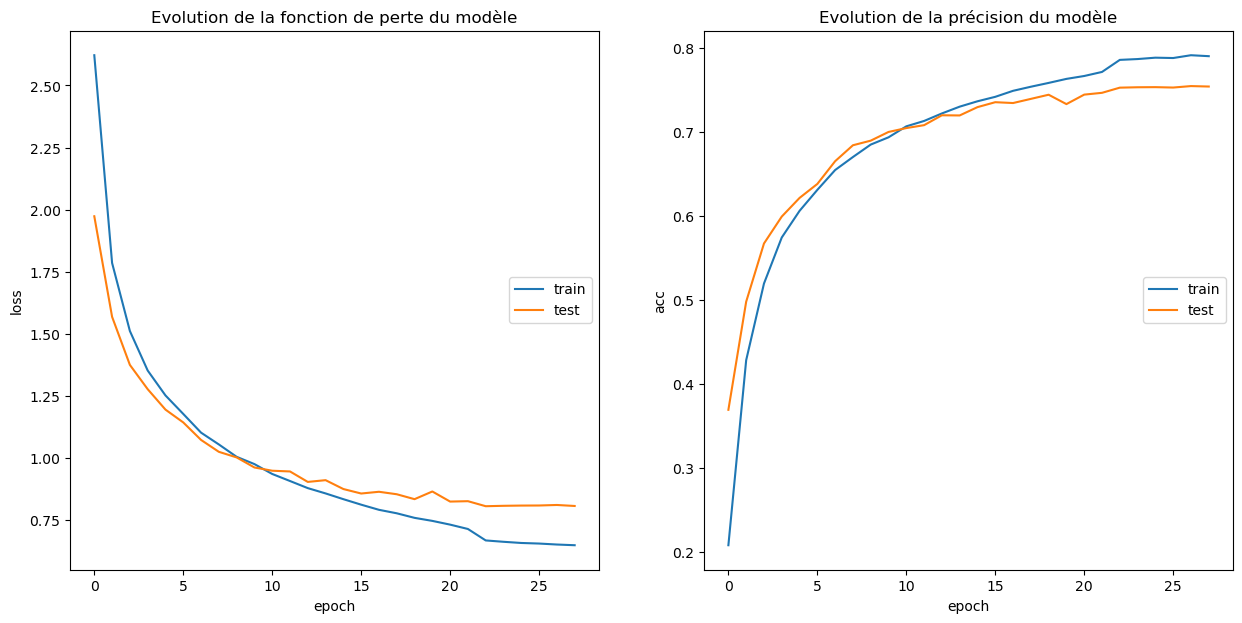

In [60]:
train_loss = training_history_RNNft.history["loss"]
val_loss = training_history_RNNft.history["val_loss"]
train_acc = training_history_RNNft.history["accuracy"]
val_acc = training_history_RNNft.history["val_accuracy"]

plt.figure(figsize = (15, 7))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Evolution de la fonction de perte du modèle')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Evolution de la précision du modèle')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.savefig('modelRNNft_history_loss_acc.png')
plt.show()

In [61]:
test_pred = modelRNNft.predict(X_test)
test_pred_class = np.argmax(test_pred, axis=1)

test_pred_class = encoder.inverse_transform(test_pred_class)
y_test_class = encoder.inverse_transform(y_test)

print(classification_report(y_test_class, test_pred_class))

468/468 [==============================] - 51s 109ms/step
              precision    recall  f1-score   support

          10       0.38      0.61      0.47       561
          40       0.57      0.53      0.55       442
          50       0.74      0.79      0.76       286
          60       0.93      0.86      0.89       159
        1140       0.63      0.74      0.68       447
        1160       0.79      0.86      0.83       665
        1180       0.58      0.52      0.55       117
        1280       0.63      0.59      0.61       875
        1281       0.70      0.46      0.56       336
        1300       0.81      0.91      0.86       920
        1301       0.84      0.76      0.80       133
        1302       0.76      0.72      0.74       447
        1320       0.75      0.72      0.73       611
        1560       0.73      0.78      0.76       905
        1920       0.85      0.89      0.87       752
        1940       0.75      0.71      0.73       121
        2060       0.73

In [62]:
modelRNNft.save('text_FastText.h5')

#### 2.4.3. RNN embedding avec Word2Vec (skip-gram) 

Tous les deux algorithme, CBOW et skip-gram du modèle Word2Vec ont été testé. C'est skip-gram qui donne un meilleur score.



In [41]:
# initialisation du modele Word2Vec
w2v_model = Word2Vec(min_count=2, #la fréquence minimale des mots à prendre en compte
                     window=5, #la distance maximale entre le mot actuel et le mot prédit dans une phrase
                     vector_size=300, #la dimension de l'embedding
                     sg = 1, # 1 pour l'algorithme skip-gram; autrement CBOW.
                     negative=10, #la variable qui contrôle l'échantillonnage négatif
                     seed=1)

In [42]:
# contruction des vocabulaire à partir de sequence de donnée de texte
sentences = [str(line).split() for line in X_text_train]
w2v_model.build_vocab(sentences, progress_per=10000)

In [43]:
w2v_vocab = list(w2v_model.wv.index_to_key)
print('Vocabulary size: %d' % len(w2v_vocab))

Vocabulary size: 36397


In [44]:
# entrainement du modele word2vec 
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)

(73003221, 75225390)

In [45]:
# creation d'une matrice d'embedding pour chaque mot dans notre dataset word2idx
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word2idx.items():
    if word in w2v_vocab :
        embedding_matrix[i] = w2v_model.wv[word]

In [46]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.005, patience = 5, mode = 'max', 
                               restore_best_weights = True, verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', min_delta = 0.01, factor = 0.1, 
                                         patience = 3, cooldown = 4, verbose=1)

In [47]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            input_length=max_length, trainable=False)


modelRNNwv = Sequential()
modelRNNwv.add(embedding_layer)
modelRNNwv.add(RNN(GRUCell(128), return_sequences=True))
modelRNNwv.add(Dropout(0.3))
modelRNNwv.add(GlobalAveragePooling1D())
modelRNNwv.add(Dense(256, activation='relu'))
modelRNNwv.add(Dropout(0.3))
modelRNNwv.add(Dense(27, activation='softmax'))

modelRNNwv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 450, 300)          18850800  
                                                                 
 rnn (RNN)                   (None, 450, 128)          165120    
                                                                 
 dropout (Dropout)           (None, 450, 128)          0         
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [48]:
modelRNNwv.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


training_history_RNNwv = modelRNNwv.fit(X_train, y_train, batch_size = 300, epochs=50, 
                             validation_data = [X_test, y_test],
                             callbacks= [early_stopping, reduce_learning_rate],
                             verbose = True)

Epoch 1/50
200/200 [==============================] - 206s 1s/step - loss: 2.0750 - accuracy: 0.3664 - val_loss: 1.3165 - val_accuracy: 0.5677 - lr: 0.0010
Epoch 2/50
200/200 [==============================] - 206s 1s/step - loss: 1.1330 - accuracy: 0.6351 - val_loss: 0.9254 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 3/50
200/200 [==============================] - 205s 1s/step - loss: 0.8725 - accuracy: 0.7253 - val_loss: 0.8110 - val_accuracy: 0.7412 - lr: 0.0010
Epoch 4/50
200/200 [==============================] - 204s 1s/step - loss: 0.7618 - accuracy: 0.7596 - val_loss: 0.7367 - val_accuracy: 0.7639 - lr: 0.0010
Epoch 5/50
200/200 [==============================] - 210s 1s/step - loss: 0.6905 - accuracy: 0.7834 - val_loss: 0.7109 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 6/50
200/200 [==============================] - 205s 1s/step - loss: 0.6390 - accuracy: 0.7970 - val_loss: 0.6767 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 7/50
200/200 [==============================] - 207s 1s/st

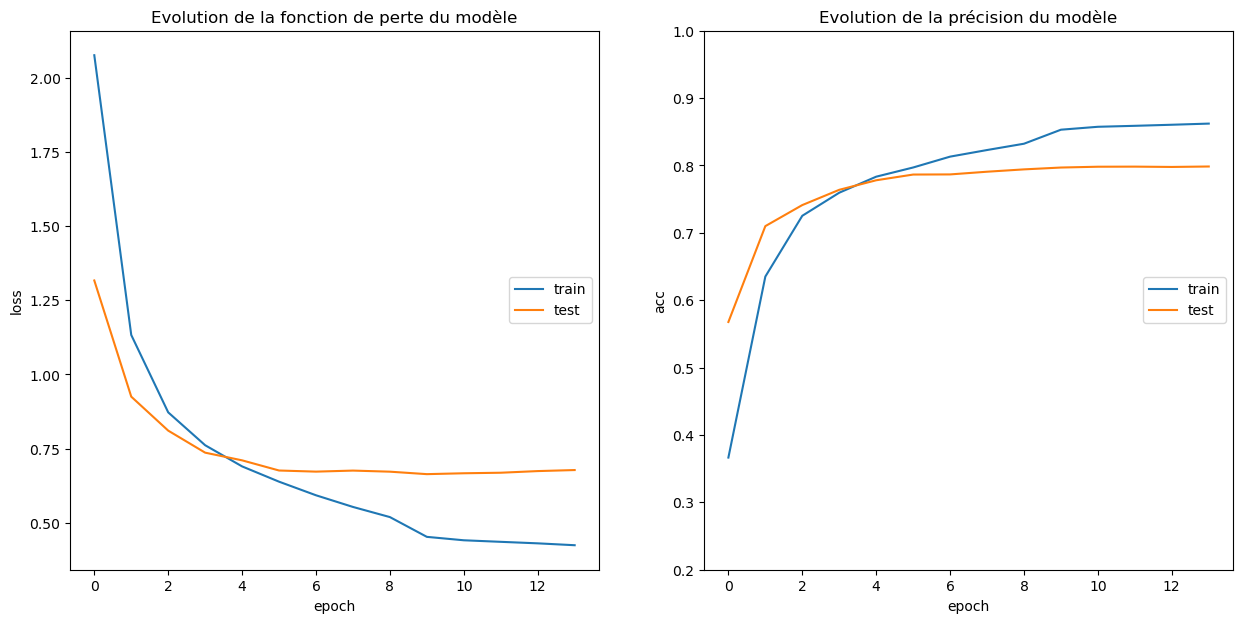

In [51]:
train_loss = training_history_RNNwv.history["loss"]
val_loss = training_history_RNNwv.history["val_loss"]
train_acc = training_history_RNNwv.history["accuracy"]
val_acc = training_history_RNNwv.history["val_accuracy"]

plt.figure(figsize = (15, 7))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Evolution de la fonction de perte du modèle')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title("Evolution de la précision du modèle")
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.ylim(0.2, 1)

plt.savefig('modelRNNwv_skip-gram_history_loss_acc.png')
plt.show()

In [52]:
test_pred = modelRNNwv.predict(X_test)

468/468 [==============================] - 47s 100ms/step


In [53]:
test_pred_class = np.argmax(test_pred, axis=1)

test_pred_class = encoder.inverse_transform(test_pred_class)
y_test_class = encoder.inverse_transform(y_test)

print(classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

          10       0.39      0.58      0.47       561
          40       0.56      0.64      0.60       442
          50       0.84      0.85      0.84       286
          60       0.94      0.89      0.91       159
        1140       0.70      0.80      0.75       447
        1160       0.90      0.87      0.88       665
        1180       0.64      0.54      0.59       117
        1280       0.67      0.78      0.72       875
        1281       0.71      0.54      0.61       336
        1300       0.94      0.93      0.94       920
        1301       0.89      0.85      0.87       133
        1302       0.85      0.74      0.79       447
        1320       0.83      0.77      0.80       611
        1560       0.84      0.77      0.80       905
        1920       0.86      0.92      0.89       752
        1940       0.78      0.78      0.78       121
        2060       0.72      0.80      0.76       869
        2220       0.82    

In [54]:
modelRNNwv.save('text_W2V_Skip-gram.h5')

Tous les deux modèles en Deep learning présentés ci-dessus montrent moins de sur-apprentissage par rapport au modèles de Machine Learning. Finalement, le modèle **RNN Embedding avec Word2Vec en skip-gram** est choisi comme le meilleur modèle qui donne un score d'accuracy de 0.794 pour le dataset de test.